In [ ]:
Business Problem

Telecommunication companies lose significant revenue when customers cancel their service.
The goal of this project is to predict customer churn and identify key drivers behind churn to support proactive retention strategies.

📌 What is Churn (for this dataset)

Churn = “Yes” → Customer left the company

Churn = “No” → Customer stayed

This is a binary classification problem.

🎯 Business KPI

Primary KPI: Reduce customer churn rate

Target:

Reduce churn by 10–15% by identifying high-risk customers before they leave.

💡 Business Value

Retaining customers is 5x cheaper than acquiring new ones

Predictive churn models allow targeted offers instead of mass discounts

In [2]:
import pandas as pd
import numpy as np
!pip install xgboost


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# Explainability
import shap

sns.set(style="whitegrid")


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 487.6 kB/s eta 0:02:28
   ---------------------------------------- 0.0/72.0 MB 487.6 kB/s eta 0:02:28
   ---------------------------------------- 0.1/72.0 MB 409.6 kB/s eta 0:02:56
   ---------------------------------------- 0.1/72.0 MB 504.4 kB/s eta 0:02:23
   ---------------------------------------- 0.2/72.0 MB 573.4 kB/s eta 0:02:06
   ---------------------------------------- 0.2/72.0 MB 687.0 kB/s eta 0:01:45
   ---------------------------------------- 0.3/72.0 MB 714.4 kB/s eta 0:01:41
   ---------------------------------------- 0.3/72.0 MB 731.4 kB/s eta 0:01:38
   ---------------------------------------- 0.3/72.0 MB 701.4 kB/s eta 0:01:43
   ---------------------------------------- 0.3/72.0 MB 655.4 kB/s eta 


[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'shap'

In [4]:
df = pd.read_csv(r"C:\Users\WSI\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv")


df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Target variable
df['Churn'].value_counts(normalize=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [6]:
# 3. DATA CLEANING
# 3.1 Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

In [7]:
# 3.2 Drop Customer ID
df.drop('customerID', axis=1, inplace=True)

In [8]:
# 4. FEATURE ENGINEERING (VERY IMPORTANT)
# 4.1 Customer Lifetime
df['Customer_Lifetime'] = df['tenure']

In [9]:
# 4.2 Average Monthly Spend
df['AvgMonthlySpend'] = np.where(
    df['tenure'] > 0,
    df['TotalCharges'] / df['tenure'],
    0
)

In [10]:
# 4.3 Contract Risk Score
contract_risk = {
    'Month-to-month': 3,
    'One year': 2,
    'Two year': 1
}

df['Contract_Risk'] = df['Contract'].map(contract_risk)

In [12]:
# 5. ENCODING
# 5.1 Encode Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [13]:
# 5.2 Encode Binary Columns
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and col != 'Churn']

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [14]:
# 5.3 One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

In [15]:
# 6. TRAIN / TEST SPLIT
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [17]:
# 7. FEATURE SCALING (FOR LOGISTIC REGRESSION)
scaler = StandardScaler()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 
            'Customer_Lifetime', 'AvgMonthlySpend']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [19]:
# 8. MODELING
# 8.1 Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

lr_preds = lr.predict(X_test_scaled)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]


In [20]:
lr_probs

array([0.04615885, 0.69791571, 0.05993792, ..., 0.15412192, 0.00422937,
       0.00632159])

In [21]:
# 8.2 Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [22]:
rf_preds

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
# 8.3 XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

In [24]:
# 🔹 9. EVALUATION
# 9.1 ROC-AUC
print("Logistic ROC-AUC:", roc_auc_score(y_test, lr_probs))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_probs))

Logistic ROC-AUC: 0.8423441576894262
Random Forest ROC-AUC: 0.8420109018574491
XGBoost ROC-AUC: 0.8388682218605493


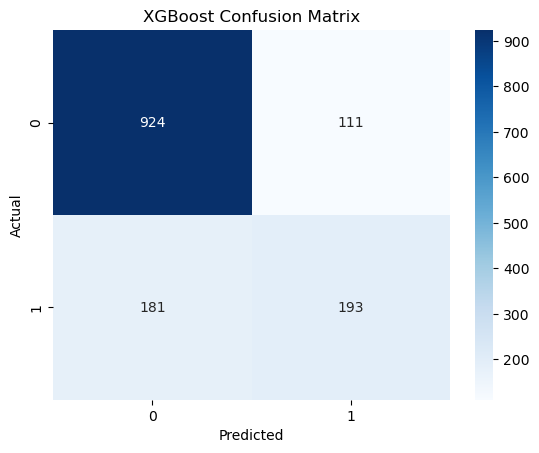

In [25]:
# 9.2 Confusion Matrix (XGBoost)
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
# 9.3 Classification Report
print(classification_report(y_test, xgb_preds))


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [33]:
# 10. EXPLAINABILITY (SHAP 🔥)
!python -m pip install --upgrade pip




Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [34]:
!pip install shap


Defaulting to user installation because normal site-packages is not writeable


In [36]:
import shap

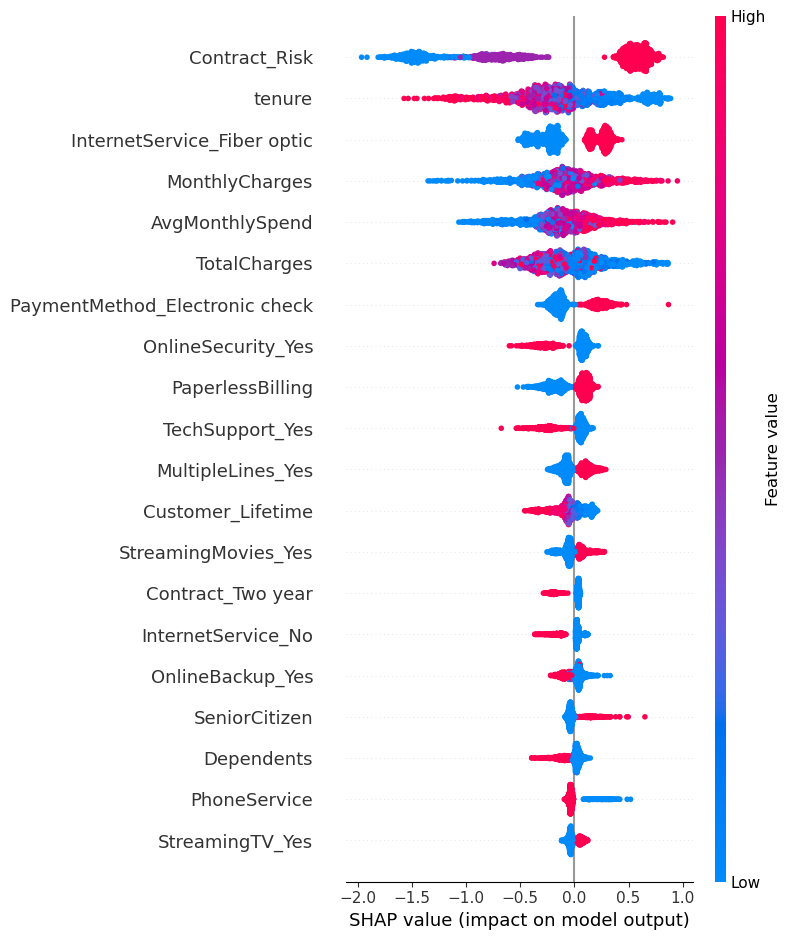

In [37]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [38]:
# 11. FEATURE IMPORTANCE
importance = pd.Series(xgb.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(10)

Contract_Risk                           0.196015
InternetService_Fiber optic             0.191561
Contract_Two year                       0.118892
OnlineSecurity_No internet service      0.068161
InternetService_No                      0.060187
DeviceProtection_No internet service    0.036305
Customer_Lifetime                       0.030604
OnlineBackup_No internet service        0.029477
PaymentMethod_Electronic check          0.019111
tenure                                  0.017715
dtype: float32

In [40]:
# 12. BUSINESS INSIGHTS (FOR REPORT)
high_risk = X_test.copy()
high_risk['Churn_Prob'] = xgb_probs

high_risk.sort_values('Churn_Prob', ascending=False).head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Customer_Lifetime,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Prob
2631,1,1,1,0,7,1,1,99.25,665.45,7,...,False,True,False,True,False,False,False,True,False,0.966457
3380,1,1,1,0,1,1,1,95.10,95.10,1,...,False,True,False,True,False,False,False,True,False,0.958256
6866,1,0,0,0,1,1,1,95.45,95.45,1,...,False,True,False,True,False,False,False,True,False,0.953224
6623,1,1,0,0,1,1,1,76.45,76.45,1,...,False,False,False,False,False,False,False,True,False,0.952331
4585,0,1,0,0,1,1,1,85.05,85.05,1,...,False,False,False,True,False,False,False,True,False,0.947430
2464,0,0,0,0,1,1,1,77.15,77.15,1,...,False,False,False,False,False,False,False,True,False,0.946601
1073,1,0,0,0,7,1,1,98.05,713.00,7,...,False,True,False,True,False,False,False,False,False,0.939918
1731,0,1,0,0,1,1,1,69.60,69.60,1,...,False,False,False,False,False,False,False,True,False,0.937181
2280,0,1,0,0,8,1,1,100.15,908.55,8,...,False,True,False,True,False,False,True,False,False,0.933454
383,1,0,0,0,1,1,1,90.85,90.85,1,...,False,False,False,True,False,False,True,False,False,0.931178
